# Pitch Tipping Via Human Pose Estimation and Time Series Classification by Justin Feldman 
## Classification Modeling and Analysis:
#### This file is designed to help you evaluate whether there is actionable pitch tipping insights or not. The various test % results indicate if the models trained on your pitcher's biomechanic data can accurately predict what pitch the pitcher is throwing before the point of release.

#### 1. Multinomial Logistic Regression
#### 2. Support Vector Machines
#### 3. Deep Neural Networks

#### Input your data in the cell below:

In [14]:
pitcher_name = 'Brayan Bello' # Pitcher's name (First Last)
processed_data_path = '/Users/justinfeldman/Library/Mobile Documents/com~apple~CloudDocs/CS6140/Final Project/Pitcher Data/Bello_Brayan/bello_brayan_processed.json' # Your processed data file path
save_your_models = '/Users/justinfeldman/Library/Mobile Documents/com~apple~CloudDocs/CS6140/Final Project/Pitcher Data/Bello_Brayan' # Directory to save models to for future use

In [15]:
import json
import random
import time
from copy import deepcopy
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import pickle
import joblib
from datetime import datetime
import shap
warnings.filterwarnings("ignore", category=UserWarning)

def load_processed_data(json_file_path):
    """
    Load processed data from a JSON file back into a list of dataframes.
    
    Parameters:
    json_file_path (str): Path to the JSON file containing processed data
    
    Returns:
    list: List of dictionaries, each containing a dataframe and metadata
    """

    
    # Load the JSON data
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Convert back to the original format
    dataframes_processed = []
    
    for item in data:
        # Convert the dict records back to a DataFrame
        df = pd.DataFrame(item['dataframe'])
        
        # Create the same structure as the original dataframes_processed
        dataframes_processed.append({
            'dataframe': df,
            'pitch_type': item['pitch_type'],
            'video_index': item['video_index'],
            'filename': item['filename']
        })
    
    return dataframes_processed

def flatten_data_for_analysis(dataframes):
    
    # Lists to store features and targets
    all_features = []
    all_targets = []
    landmarks = [
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_hip',
        'right_hip',
        'left_knee',
        'right_knee',
        'face',
        'left_hand',
        'right_hand',
        'left_foot',
        'right_foot'
        ]

    # Process each video
    for video_data in dataframes:
        pitch_type = video_data['pitch_type']
        df = video_data['dataframe']
        
        # Initialize a list for this video's flattened features
        video_features = []
        
        # For each frame, extract and flatten selected landmark coordinates
        for frame_idx in range(len(df)):
            frame_data = df.iloc[frame_idx]
            
            # Extract coordinates for selected landmarks
            for landmark in landmarks:
                # Find the relevant coordinate columns for this landmark
                x_col = f'{landmark}_x'
                y_col = f'{landmark}_y'
                presence_col = f'{landmark}_presence'
                
                # Add x and y coordinates to features
                video_features.append(frame_data[x_col])
                video_features.append(frame_data[y_col])
                video_features.append(frame_data[presence_col])
        
        # Add this video's features to the lists
        all_features.append(video_features)
        all_targets.append(pitch_type)
    
    # Create DataFrames
    X_pitches = pd.DataFrame(all_features)
    y_pitches = pd.Series(all_targets, name='pitch_type')
    
    return X_pitches, y_pitches

def save_model(model, model_name, save_flag=False, directory='saved_models'):
    if not save_flag:
        return None
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    
    # Generate timestamp for unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create filename with model name and timestamp
    filename = f"{model_name}_{timestamp}.pkl"
    filepath = os.path.join(directory, filename)
    
    # Save the model
    joblib.dump(model, filepath)
    print(f"Model '{model_name}' saved to {filepath}")
    
    return filepath

dataframes = load_processed_data(processed_data_path)
X_pitches, y_pitches = flatten_data_for_analysis(dataframes)

## Logistic Regression

This section implements a standard multiclassification method:

- **Multinomial Logistic Regression**: Effective for classifying linearly separable and distinct high dimensional data. [Read more...](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Logistic%20regression%20is%20a%20supervised,based%20on%20patient%20test%20results.)

Note: Given the temporal nature, overall complexity, and nonlinearity of your pitcher's dataset, the expectation is that you will not see good accuracy results from support vector machine analysis. The likely result is a significantly lower test % than train % indicating an inability to converge to accurate class separation. A high train % value is likely a result of data overfitting. 

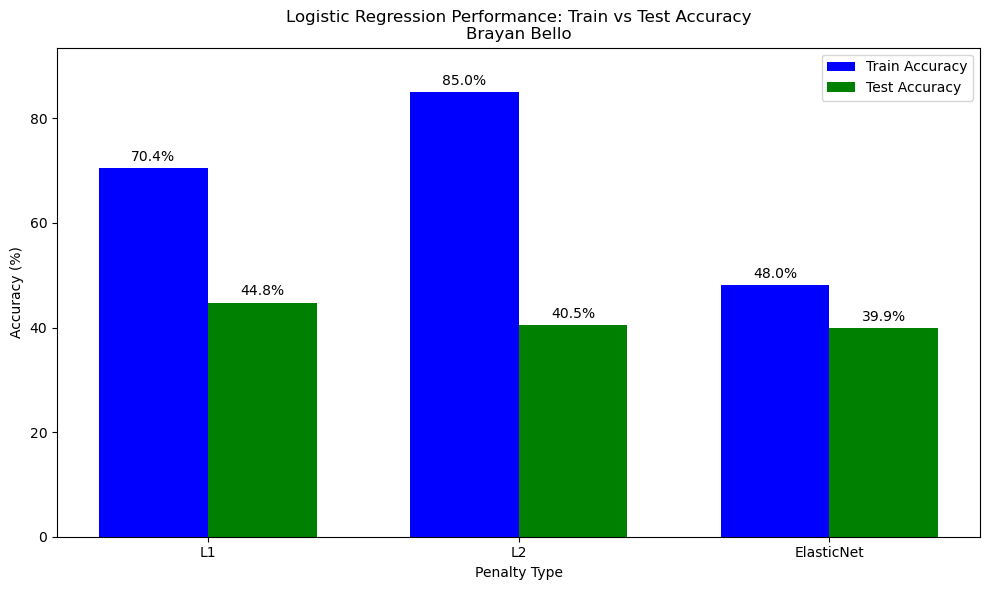

In [16]:
# Logistic regression setup and running. Do not touch this cell 
from sklearn.linear_model import LogisticRegression

def log_reg_model_setup(loss, X_pitches, y_pitches):

    x_train, x_test, y_train, y_test = train_test_split(X_pitches, y_pitches, stratify=y_pitches)

    scaler = StandardScaler()
    x_train, x_test = scaler.fit_transform(x_train), scaler.fit_transform(x_test)

    if loss == 'l1':
        reg_model = LogisticRegression(penalty=loss, solver='liblinear')
    elif loss == 'elasticnet':
        reg_model = LogisticRegression(penalty=loss, solver='saga', l1_ratio=0.5)
    else:  
        reg_model = LogisticRegression(penalty=loss, solver='lbfgs')
    
    reg_model = reg_model.fit(x_train,y_train)

    reg_model_train_accuracy = reg_model.score(x_train, y_train)
    reg_model_test_accuracy = reg_model.score(x_test, y_test)

    return reg_model, reg_model_train_accuracy, reg_model_test_accuracy

def log_reg_plot(l1_model_train_accuracy, l1_model_test_accuracy,l2_model_train_accuracy, l2_model_test_accuracy, elasticnet_model_train_accuracy, elasticnet_model_test_accuracy, pitcher_name):

    penalty_types = ['L1', 'L2', 'ElasticNet']

    train_accuracies = [l1_model_train_accuracy, l2_model_train_accuracy, elasticnet_model_train_accuracy]
    test_accuracies = [l1_model_test_accuracy, l2_model_test_accuracy, elasticnet_model_test_accuracy]

    train_accuracies = [acc * 100 for acc in train_accuracies]
    test_accuracies = [acc * 100 for acc in test_accuracies]

    bar_width = 0.35
    x = np.arange(len(penalty_types))

    fig, ax = plt.subplots(figsize=(10, 6))

    train_bars = ax.bar(x - bar_width/2, train_accuracies, bar_width, label='Train Accuracy', color='blue')
    test_bars = ax.bar(x + bar_width/2, test_accuracies, bar_width, label='Test Accuracy', color='green')

    ax.set_xlabel('Penalty Type')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'Logistic Regression Performance: Train vs Test Accuracy\n{pitcher_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(penalty_types)
    ax.legend()

    ax.set_ylim(0, max(max(train_accuracies), max(test_accuracies)) * 1.1)

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(train_bars)
    add_labels(test_bars)

    plt.tight_layout()
    plt.show()

def log_reg_report(log_reg_model_train_accuracy, log_reg_model_test_accuracy, penalty):
    print(f"""
    +{'-'*20}+{'-'*12}+{'-'*12}+
    | {'Loss: ' + penalty:<18} | {'Train (%)':^10} | {'Test (%)':^10} |
    +{'-'*20}+{'-'*12}+{'-'*12}+
    | {'Accuracy':^18} | {int(np.mean(log_reg_model_train_accuracy)*100):^10} | {int(np.mean(log_reg_model_test_accuracy)*100):^10} |
    +{'-'*20}+{'-'*12}+{'-'*12}+
    """)


l1_model, l1_model_train_accuracy, l1_model_test_accuracy = log_reg_model_setup(loss= 'l1', X_pitches=X_pitches, y_pitches=y_pitches)
l2_model, l2_model_train_accuracy, l2_model_test_accuracy = log_reg_model_setup(loss= 'l2', X_pitches=X_pitches, y_pitches=y_pitches)
elasticnet_model, elasticnet_model_train_accuracy, elasticnet_model_test_accuracy = log_reg_model_setup(loss= 'elasticnet', X_pitches=X_pitches, y_pitches=y_pitches)

# log_reg_report(l1_model_train_accuracy, l1_model_test_accuracy, 'l1')
# log_reg_report(l2_model_train_accuracy, l2_model_test_accuracy, 'l2')
# log_reg_report(elasticnet_model_train_accuracy, elasticnet_model_test_accuracy, 'elasticnet')
log_reg_plot(l1_model_train_accuracy, l1_model_test_accuracy,l2_model_train_accuracy, l2_model_test_accuracy, elasticnet_model_train_accuracy, elasticnet_model_test_accuracy,pitcher_name)

Set flag to 'True' if you want to save these models for future use:

In [17]:
save_flag = False

save_model(l1_model, 'log_reg_l1', save_flag, directory=save_your_models)
save_model(l2_model, 'log_reg_l2', save_flag, directory=save_your_models)
save_model(elasticnet_model, 'log_reg_elastic', save_flag, directory=save_your_models)

## SVM's

This section implements a more flexible classifier than the logistic regression model:

- **Support Vector Machines (SVM)**: Effective for capturing classifications in higher dimensions with better handling of outlier data than logistic regression. [Read More...](https://www.ibm.com/think/topics/support-vector-machine)

Note: Given the temporal nature, overall complexity, and nonlinearity of your pitcher's dataset, the expectation is that you will not see good accuracy results from support vector machine analysis. The likely result is a significantly lower test % than train % indicating an inability to converge to accurate class separation. A high train % value is likely the result of data overfitting.

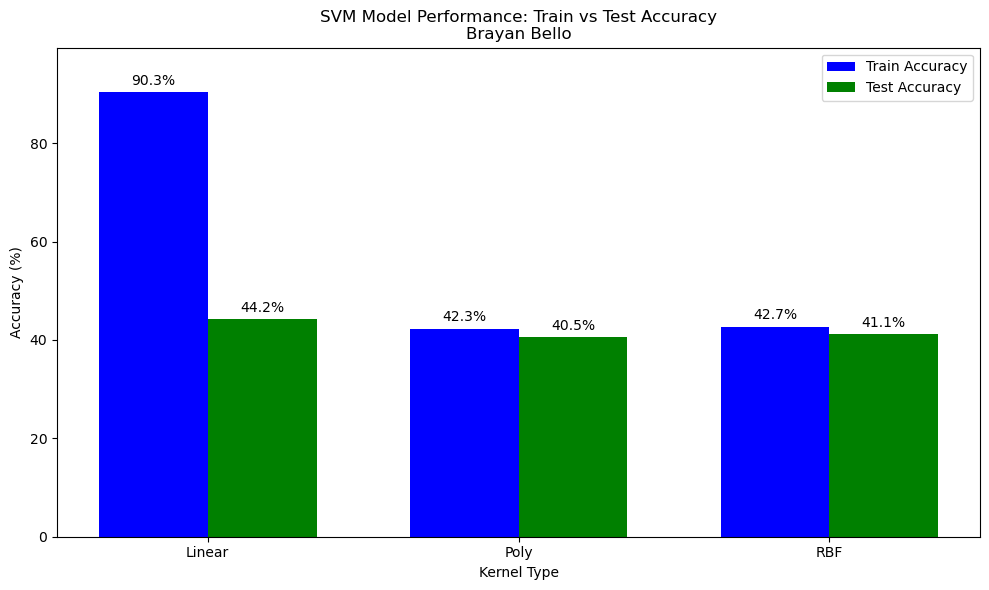

In [18]:
# SVM setup and running. Do not touch this cell 
def svm_model_setup(kernel, X_pitches, y_pitches):
    x_train, x_test, y_train, y_test = train_test_split(X_pitches, y_pitches,stratify=y_pitches)

    scaler = StandardScaler()
    x_train, x_test = scaler.fit_transform(x_train), scaler.fit_transform(x_test)
    
    svm_model = svm.SVC(kernel=kernel)
    svm_model = svm_model.fit(x_train,y_train)
    
    svm_model_train_accuracy = svm_model.score(x_train, y_train)
    svm_model_test_accuracy = svm_model.score(x_test, y_test)

    return svm_model, svm_model_train_accuracy, svm_model_test_accuracy

def svm_plot(linear_model_train_accuracy, linear_model_test_accuracy,poly_model_train_accuracy, poly_model_test_accuracy,rbf_model_train_accuracy, rbf_model_test_accuracy, pitcher_name):

    kernels = ['Linear', 'Poly', 'RBF']

    train_accuracies = [linear_model_train_accuracy, poly_model_train_accuracy, rbf_model_train_accuracy]
    test_accuracies = [linear_model_test_accuracy, poly_model_test_accuracy, rbf_model_test_accuracy]

    train_accuracies = [acc * 100 for acc in train_accuracies]
    test_accuracies = [acc * 100 for acc in test_accuracies]

    bar_width = 0.35
    x = np.arange(len(kernels))

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    train_bars = ax.bar(x - bar_width/2, train_accuracies, bar_width, label='Train Accuracy', color='blue')
    test_bars = ax.bar(x + bar_width/2, test_accuracies, bar_width, label='Test Accuracy', color='green')

    ax.set_xlabel('Kernel Type')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'SVM Model Performance: Train vs Test Accuracy\n{pitcher_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(kernels)
    ax.legend()

    ax.set_ylim(0, max(max(train_accuracies), max(test_accuracies)) * 1.1)

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(train_bars)
    add_labels(test_bars)

    plt.tight_layout()
    plt.show()

def svm_report(svm_model_train_accuracy, svm_model_test_accuracy, kernel):
    print(f"""
    +{'-'*20}+{'-'*12}+{'-'*12}+
    | {'Kernel: ' + kernel:<18} | {'Train (%)':^10} | {'Test (%)':^10} |
    +{'-'*20}+{'-'*12}+{'-'*12}+
    | {'Accuracy':^18} | {int(np.mean(svm_model_train_accuracy)*100):^10} | {int(np.mean(svm_model_test_accuracy)*100):^10} |
    +{'-'*20}+{'-'*12}+{'-'*12}+
    """)

svm_model_linear, linear_model_train_accuracy, linear_model_test_accuracy = svm_model_setup(kernel='linear', X_pitches=X_pitches, y_pitches=y_pitches)
svm_model_poly, poly_model_train_accuracy, poly_model_test_accuracy = svm_model_setup(kernel= 'poly', X_pitches=X_pitches, y_pitches=y_pitches)
svm_model_rbf, rbf_model_train_accuracy, rbf_model_test_accuracy = svm_model_setup(kernel= 'rbf', X_pitches=X_pitches, y_pitches=y_pitches)

# svm_report(linear_model_train_accuracy, linear_model_test_accuracy, 'Linear')
# svm_report(poly_model_train_accuracy, poly_model_test_accuracy, 'Poly')
# svm_report(rbf_model_train_accuracy, rbf_model_test_accuracy, 'RBF')

svm_plot(linear_model_train_accuracy, linear_model_test_accuracy,poly_model_train_accuracy, poly_model_test_accuracy,rbf_model_train_accuracy, rbf_model_test_accuracy,pitcher_name)


Set flag to 'True' if you want to save these models for future use:

In [19]:
save_flag = False

save_model(svm_model_linear, 'svm_linear_kernel', save_flag, directory=save_your_models)
save_model(svm_model_poly, 'svm_poly_kernel', save_flag, directory=save_your_models)
save_model(svm_model_rbf, 'svm_rbf_kernel', save_flag, directory=save_your_models)

## RNN and LSTM Neural Networks

This section implements two powerful sequential data processing architectures:

- **Recurrent Neural Network (RNN)**: Effective for capturing short-term dependencies [Read more...](https://www.ibm.com/think/topics/recurrent-neural-networks)
- **Long Short-Term Memory (LSTM)**: Specialized for handling long-term dependencies [Read more...](https://medium.com/@rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce)

### Genetic Algorithm Hyperparameter Optimization

We employ an evolutionary approach to discover optimal model configurations automatically. [Read more...](https://www.justinafeldman.com/music-reconstruction-using-genetic-alg)

> *"Genetic algorithms are a robust genre of algorithms inspired by the theories of natural selection and evolution. Given a population of individuals represented as a structured data set, the genetic algorithm architecture creates an artificial natural selection environment in which the strongest individuals survive based on the strength of their 'genetics'. These surviving individuals remain in the population to produce offspring that carry combinations of the parents' genetics along with novel genetic mutations as they occur naturally in living beings. These offspring potentially possess a stronger genetic composition, improving the population's traits overall as the evolutionary process continues."* 
> 
> — Jiwani, Feldman et al. (2024)

### Genetic Encoding

Each model "gene" in the population encodes the following hyperparameters:

| Parameter | Possible Values |
|-----------|----------------|
| Learning Rate | 0.0001, 0.0005, 0.001, 0.005, 0.01 |
| Hidden Layer Depth | 1, 2, 3, 4, 5 |
| Hidden Layer Size | 16, 32, 64, 128, 256 |
| Training Epochs | 5-50 |
| Architecture Type | RNN or LSTM |

### Fitness Function

The fitness evaluation prioritizes:
1. **Maximizing predictive performance**
2. **Avoiding overfitting**

The evolution process will iteratively select the best-performing models and combine their characteristics to discover increasingly effective architectures.

In [20]:
# RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.rnn(x, h0)
        logit = self.fc(out[:, -1, :])
        prob = nn.functional.softmax(logit, dim=1)
    
        return prob, logit
    
# LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        logit = self.fc(out[:, -1, :])
        prob = nn.functional.softmax(logit, dim=1)
    
        return prob, logit

Starting genetic algorithm with 30 individuals for 5 generations
This can take upwards of 10 minutes

Generation 1/5
Best in generation 1: Model: RNN, Epochs: 39, LR: 0.0005, Hidden Size: 32, Layers: 4, Fitness: 0.5909, Train Acc: 0.7519, Test Acc: 0.6231
Generation time: 176.00 seconds

Generation 2/5
Best in generation 2: Model: RNN, Epochs: 39, LR: 0.0005, Hidden Size: 32, Layers: 4, Fitness: 0.5909, Train Acc: 0.7519, Test Acc: 0.6231
Generation time: 78.39 seconds

Generation 3/5
Best in generation 3: Model: RNN, Epochs: 39, LR: 0.0005, Hidden Size: 32, Layers: 4, Fitness: 0.5909, Train Acc: 0.7519, Test Acc: 0.6231
Generation time: 97.09 seconds

Generation 4/5
Best in generation 4: Model: RNN, Epochs: 39, LR: 0.0005, Hidden Size: 32, Layers: 4, Fitness: 0.5909, Train Acc: 0.7519, Test Acc: 0.6231
Generation time: 89.68 seconds

Generation 5/5
Best in generation 5: Model: RNN, Epochs: 39, LR: 0.0005, Hidden Size: 32, Layers: 4, Fitness: 0.5909, Train Acc: 0.7519, Test Acc: 0.6231

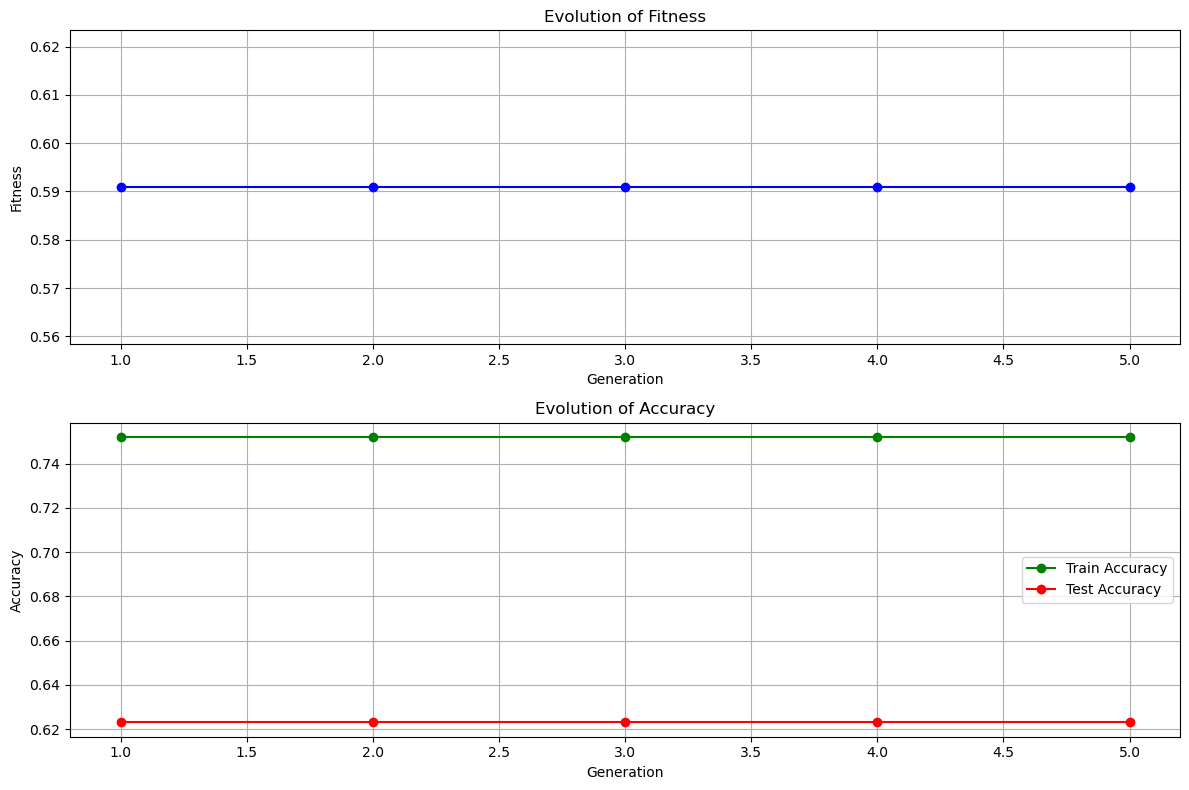

In [21]:
def prepare_data(dataframes):
    # Extract features and labels
    X = []  # List to store feature tensors
    y = []  # List to store labels
    
    # Create a mapping for pitch types to numeric indices
    unique_pitch_types = set(item['pitch_type'] for item in dataframes)
    pitch_type_to_idx = {pitch: idx for idx, pitch in enumerate(sorted(unique_pitch_types))}
    idx_to_pitch_type = {idx: pitch for pitch, idx in pitch_type_to_idx.items()}
    
    # Process each dataframe
    for item in dataframes:
        # Get the dataframe with landmark coordinates
        df = item['dataframe']
        
        # Convert dataframe to numpy array (frames × features)
        features = df.values.astype(np.float32)

        # Normalize per sample
        mean = np.mean(features, axis=0, keepdims=True)
        std = np.std(features, axis=0, keepdims=True) + 1e-8 
        features_normalized = (features - mean) / std

        # Get the label (pitch type)
        label = pitch_type_to_idx[item['pitch_type']]
        
        X.append(features_normalized)
        y.append(label)
    
    # Convert lists to numpy arrays
    X = np.array(X) # (num_samples, num_frames, num_features)
    y = np.array(y)
    
    return X, y, pitch_type_to_idx, idx_to_pitch_type

# Gene class to represent a set of hyperparameters
class Gene:
    def __init__(self, model_type=None, num_epochs=None, lr=None, hidden_size=None, num_layers=None):
        # Initialize with random values if not provided
        self.model_type = model_type if model_type is not None else random.choice([RNN, LSTM])
        self.num_epochs = num_epochs if num_epochs is not None else random.randint(5, 50)
        self.lr = lr if lr is not None else random.choice([0.0001, 0.0005, 0.001, 0.005, 0.01])
        self.hidden_size = hidden_size if hidden_size is not None else random.choice([16, 32, 64, 128, 256])
        self.num_layers = num_layers if num_layers is not None else random.randint(1, 5)
        self.fitness = 0
        self.train_accuracy = 0
        self.test_accuracy = 0
        
    def __str__(self):
        model_name = "RNN" if self.model_type == RNN else "LSTM"
        return (f"Model: {model_name}, Epochs: {self.num_epochs}, LR: {self.lr}, "
                f"Hidden Size: {self.hidden_size}, Layers: {self.num_layers}, "
                f"Fitness: {self.fitness:.4f}, Train Acc: {self.train_accuracy:.4f}, Test Acc: {self.test_accuracy:.4f}")
    
    def to_dict(self):
        model_name = "RNN" if self.model_type == RNN else "LSTM"
        return {
            "model_type": model_name,
            "num_epochs": self.num_epochs,
            "learning_rate": self.lr,
            "hidden_size": self.hidden_size,
            "num_layers": self.num_layers,
            "fitness": self.fitness,
            "train_accuracy": self.train_accuracy,
            "test_accuracy": self.test_accuracy
        }

# Genetic Algorithm class
class GeneticAlgorithm:
    def __init__(self, X_data, y_data, input_size, num_classes, 
                 population_size=10, num_generations=5, 
                 mutation_rate=0.2, crossover_rate=0.7,
                 batch_size=16, test_size=0.2, SEED=42):
        
        self.input_size = input_size
        self.num_classes = num_classes
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.batch_size = batch_size
        self.history = []
        self.SEED = SEED
        
        # Setup data
        self.X_tensor = torch.FloatTensor(X_data)
        self.y_tensor = torch.LongTensor(y_data)
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_tensor, self.y_tensor, test_size=test_size, random_state=SEED, stratify=self.y_tensor
        )
        
        # Create datasets
        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.test_dataset = TensorDataset(self.X_test, self.y_test)
        
        # Initialize population
        self.population = [Gene() for _ in range(population_size)]
        
    def model_trainer(self, gene):
        """Train a model based on the gene's hyperparameters"""
        # Use the gene's number of epochs
        epochs = gene.num_epochs
        
        # Create data loaders
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        model = gene.model_type(self.input_size, gene.hidden_size, gene.num_layers, self.num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=gene.lr)
        
        # Train the model
        model.train()
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                _, logits = model(inputs)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
        
        return model
    
    def evaluate_model(self, model, dataset):
        """Evaluate a model on the given dataset"""
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                _, logits = model(inputs)
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return correct / total
    
    def calculate_fitness(self, gene, model=None):
        """Calculate fitness based on train and test accuracy"""
        if model is None:
            # Train model
            model = self.model_trainer(gene)
        
        # Evaluate on train and test sets
        train_accuracy = self.evaluate_model(model, self.train_dataset)
        test_accuracy = self.evaluate_model(model, self.test_dataset)
        
        # Store accuracies in the gene
        gene.train_accuracy = train_accuracy
        gene.test_accuracy = test_accuracy
        
        # Calculate fitness with emphasis on test accuracy and generalization
        # Penalize if train >> test (overfitting)
        overfitting_penalty = max(0, train_accuracy - test_accuracy) * 0.25
        
        # Fitness is primarily test accuracy with a penalty for overfitting
        fitness = test_accuracy - overfitting_penalty
        gene.fitness = fitness
        
        return fitness
    
    def select_parents(self, num_parents):
        """Select parents based on tournament selection"""
        parents = []
        
        for _ in range(num_parents):
            # Tournament selection
            tournament_size = min(3, len(self.population))
            tournament = random.sample(self.population, tournament_size)
            tournament.sort(key=lambda x: x.fitness, reverse=True)
            parents.append(deepcopy(tournament[0]))
        
        return parents
    
    def crossover(self, parent1, parent2):
        """Perform crossover between two parents"""
        if random.random() > self.crossover_rate:
            return deepcopy(parent1)
        
        child = Gene()
        
        # Inherit traits with 50% chance from each parent
        child.model_type = parent1.model_type if random.random() < 0.5 else parent2.model_type
        child.num_epochs = parent1.num_epochs if random.random() < 0.5 else parent2.num_epochs
        child.lr = parent1.lr if random.random() < 0.5 else parent2.lr
        child.hidden_size = parent1.hidden_size if random.random() < 0.5 else parent2.hidden_size
        child.num_layers = parent1.num_layers if random.random() < 0.5 else parent2.num_layers
        
        return child
    
    def mutate(self, gene):
        """Perform mutation on a gene"""
        # Create a copy for mutation
        mutated_gene = deepcopy(gene)
        
        # Randomly mutate each parameter based on mutation rate
        if random.random() < self.mutation_rate:
            mutated_gene.model_type = random.choice([RNN, LSTM])
        
        if random.random() < self.mutation_rate:
            mutated_gene.num_epochs = max(5, mutated_gene.num_epochs + random.randint(-10, 10))
        
        if random.random() < self.mutation_rate:
            learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
            current_index = learning_rates.index(mutated_gene.lr) if mutated_gene.lr in learning_rates else 0
            new_index = max(0, min(len(learning_rates) - 1, current_index + random.randint(-1, 1)))
            mutated_gene.lr = learning_rates[new_index]
        
        if random.random() < self.mutation_rate:
            hidden_sizes = [16, 32, 64, 128, 256]
            current_index = hidden_sizes.index(mutated_gene.hidden_size) if mutated_gene.hidden_size in hidden_sizes else 0
            new_index = max(0, min(len(hidden_sizes) - 1, current_index + random.randint(-1, 1)))
            mutated_gene.hidden_size = hidden_sizes[new_index]
        
        if random.random() < self.mutation_rate:
            mutated_gene.num_layers = max(1, mutated_gene.num_layers + random.randint(-1, 1))
        
        return mutated_gene
    
    def evolve_population(self):
        """Evolve population through one generation"""
        # Calculate fitness for each gene
        for gene in self.population:
            if gene.fitness == 0:  # Only calculate if not already calculated
                self.calculate_fitness(gene)
        
        # Sort population by fitness
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        
        # Store best gene from this generation
        best_gene = deepcopy(self.population[0])
        self.history.append(best_gene)
        
        # Select parents
        num_parents = max(2, self.population_size // 2)
        parents = self.select_parents(num_parents)
        
        # Create new population
        new_population = []
        
        # Keep the best gene (elitism)
        new_population.append(deepcopy(best_gene))
        
        # Create children through crossover and mutation
        while len(new_population) < self.population_size:
            parent1 = random.choice(parents)
            parent2 = random.choice(parents)
            
            child = self.crossover(parent1, parent2)
            child = self.mutate(child)
            
            new_population.append(child)
        
        self.population = new_population
    
    def run(self):
        """Run the genetic algorithm for specified number of generations"""
        start_time = time.time()
        
        print(f"Starting genetic algorithm with {self.population_size} individuals for {self.num_generations} generations")
        print(f"This can take upwards of 10 minutes")
        
        for generation in range(self.num_generations):
            gen_start_time = time.time()
            print(f"\nGeneration {generation+1}/{self.num_generations}")
            
            self.evolve_population()
            
            # Print best performing gene in this generation
            best_gene = self.history[-1]
            print(f"Best in generation {generation+1}: {best_gene}")
            
            gen_end_time = time.time()
            print(f"Generation time: {gen_end_time - gen_start_time:.2f} seconds")
        
        # Get best gene across all generations
        best_gene = max(self.history, key=lambda x: x.fitness)
        
        # Train the final model with the best gene
        print("\nTraining final model with best hyperparameters...")
        best_model = self.model_trainer(best_gene)
        
        # Evaluate final model
        train_accuracy = self.evaluate_model(best_model, self.train_dataset)
        test_accuracy = self.evaluate_model(best_model, self.test_dataset)
        
        end_time = time.time()
        total_time = end_time - start_time
        
        print("\n" + "="*50)
        print(f"Genetic Algorithm completed in {total_time:.2f} seconds")
        print(f"Best hyperparameters found:")
        print(best_gene)
        print(f"Final Train Accuracy: {train_accuracy:.4f}")
        print(f"Final Test Accuracy: {test_accuracy:.4f}")
        print("="*50)
        
        return best_gene, best_model, self.history
    
    def plot_history(self):
        """Plot the evolution of fitness over generations"""
        generations = list(range(1, len(self.history) + 1))
        fitness_values = [gene.fitness for gene in self.history]
        train_acc = [gene.train_accuracy for gene in self.history]
        test_acc = [gene.test_accuracy for gene in self.history]
        
        plt.figure(figsize=(12, 8))
        
        # Plot fitness
        plt.subplot(2, 1, 1)
        plt.plot(generations, fitness_values, 'b-', marker='o')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Evolution of Fitness')
        plt.grid(True)
        
        # Plot accuracies
        plt.subplot(2, 1, 2)
        plt.plot(generations, train_acc, 'g-', marker='o', label='Train Accuracy')
        plt.plot(generations, test_acc, 'r-', marker='o', label='Test Accuracy')
        plt.xlabel('Generation')
        plt.ylabel('Accuracy')
        plt.title('Evolution of Accuracy')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def get_results_table(self):
        """Create a dataframe with results for all generations"""
        results = []
        for i, gene in enumerate(self.history):
            gene_dict = gene.to_dict()
            gene_dict["generation"] = i+1
            results.append(gene_dict)
        
        return results

# Function to run the genetic algorithm
def run_genetic_algorithm(X_data, y_data, input_size, num_classes, population_size=10, num_generations=5,seed=42):
    # Set random seeds for reproducibility
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
    
    # Initialize and run the genetic algorithm
    ga = GeneticAlgorithm(
        X_data=X_data,
        y_data=y_data,
        input_size=input_size,
        num_classes=num_classes,
        population_size=population_size,
        num_generations=num_generations,
        mutation_rate=0.2,
        crossover_rate=0.7,
        batch_size=16,
        test_size=0.2,
        SEED=SEED
    )
    
    best_gene, best_model, history = ga.run()
    
    # Plot the evolution history
    ga.plot_history()
    
    # Get results table
    results = ga.get_results_table()
    
    return best_gene, best_model, results

X_data, y_data, pitch_type_to_idx, idx_to_pitch_type = prepare_data(dataframes)

input_size = X_data.shape[2]  # Number of features
num_classes = len(set(y_data))

best_gene, best_model, results = run_genetic_algorithm(X_data, y_data, input_size, num_classes, population_size=30, num_generations=5,seed=42)

Set flag to 'True' if you want to save your best model for future use:

In [22]:
save_flag = False

save_model(best_model, 'rnn_lstm_model', save_flag, directory=save_your_models)

## Convolutional Neural Network Model (CNN)

This section implements a powerful architecture typically used for image classification:

- **Recurrent Neural Network (RNN)**: Effective for capturing short-term dependencies [Read more...](https://www.ibm.com/think/topics/recurrent-neural-networks)

Observe the training and test set loss/epoch and accuracy/epoch below. Choose an epoch range to stop training the model where the train and test set losses/accuracies both improve before divergence. While the training set loss continues to go down resembling an improvement in predictive accuracy, that just represents the model overfitting to the training data. 

Convolutional Neural Networks are typically used for image classification. In essence, the landmark coordinate graphs which you can observe in the Data_Exploration file "paint a picture" of the pitcher's motions which the CNN can train with. This CNN model does not explicitly use temporal patterns the way RNN's and LSTM's do but implicitly does by looking at overall landmark trajectories' patterns.  

In [23]:
class CNN(nn.Module):
    def __init__(self, input_size, num_classes, seq_len):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.flattened_size = self._get_flattened_size(seq_len)
        
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    def _get_flattened_size(self, seq_len):
        # Calculate the sequence length after 3 pooling layers (each reduces size by factor of 2)
        seq_after_pools = seq_len // 2 // 2 // 2
        return 128 * seq_after_pools
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch_size, input_size, sequence_length]
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
    
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        prob = F.softmax(logits, dim=1)
        
        return prob, logits

In [24]:
# Training function with loss and accuracy tracking
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Cross Entropy Loss and Adam Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            probs, logits = model(inputs)
            loss = criterion(logits, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                probs, logits = model(inputs)
                loss = criterion(logits, labels)
                
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        
        # Store metrics for plotting
        epochs.append(epoch + 1)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_val_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Test Acc: {epoch_val_acc:.2f}%')
    
    # Create dictionary with training history
    history = {
        'epochs': epochs,
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }
    
    return model, history

# Function to plot the training history (both loss and accuracy)
def plot_training_history(history):
    plt.figure(figsize=(15, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['epochs'], history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(history['epochs'], history['val_loss'], 'r-o', label='Test Loss')
    plt.title('CNN Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Cross Entropy)')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['epochs'], history['train_acc'], 'g-o', label='Training Accuracy')
    plt.plot(history['epochs'], history['val_acc'], 'm-o', label='Test Accuracy')
    plt.title('CNN Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Setup data
X_tensor = torch.FloatTensor(X_data)
y_tensor = torch.LongTensor(y_data)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=SEED, stratify=y_tensor
)

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



Epoch 1/50, Train Loss: 1.2553, Test Loss: 1.2463, Train Acc: 39.42%, Test Acc: 40.77%
Epoch 2/50, Train Loss: 1.2237, Test Loss: 1.2228, Train Acc: 40.77%, Test Acc: 40.77%
Epoch 3/50, Train Loss: 1.1997, Test Loss: 1.2104, Train Acc: 40.96%, Test Acc: 42.31%
Epoch 4/50, Train Loss: 1.1779, Test Loss: 1.2088, Train Acc: 45.38%, Test Acc: 43.85%
Epoch 5/50, Train Loss: 1.1368, Test Loss: 1.1667, Train Acc: 47.50%, Test Acc: 50.00%
Epoch 6/50, Train Loss: 1.0865, Test Loss: 1.1902, Train Acc: 52.88%, Test Acc: 43.85%
Epoch 7/50, Train Loss: 1.0326, Test Loss: 1.1242, Train Acc: 53.85%, Test Acc: 46.15%
Epoch 8/50, Train Loss: 0.8996, Test Loss: 1.1162, Train Acc: 60.77%, Test Acc: 49.23%
Epoch 9/50, Train Loss: 0.7820, Test Loss: 1.0859, Train Acc: 68.27%, Test Acc: 51.54%
Epoch 10/50, Train Loss: 0.6513, Test Loss: 1.2532, Train Acc: 73.85%, Test Acc: 52.31%
Epoch 11/50, Train Loss: 0.5730, Test Loss: 1.4167, Train Acc: 77.88%, Test Acc: 44.62%
Epoch 12/50, Train Loss: 0.4327, Test Los

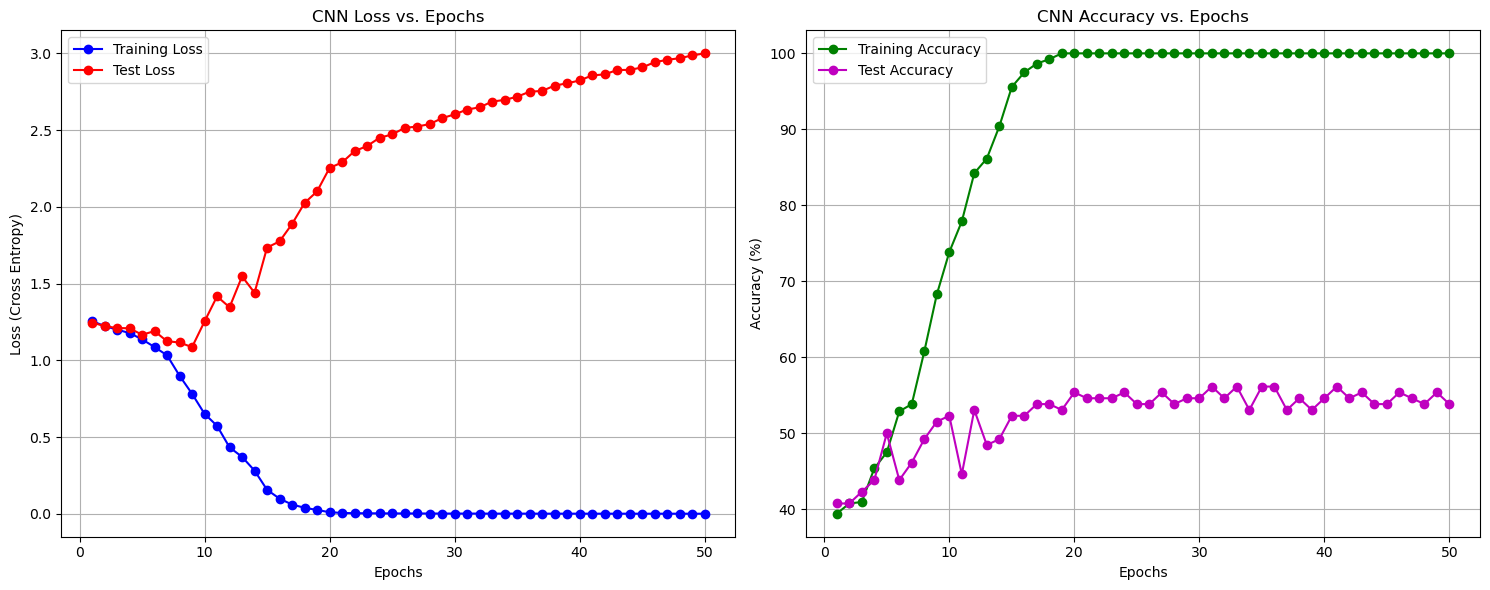

In [25]:
# Change number of epochs here
'___________________'
num_epochs = 50
'___________________'

model = CNN(input_size=X_data.shape[2], num_classes=len(torch.unique(y_train)), seq_len=24)
cnn_model, history = train_model(model, train_loader, test_loader, num_epochs)

plot_training_history(history)

Set flag to 'True' if you want to save your best model for future use:

In [26]:
save_flag = False

save_model(cnn_model, 'cnn_model', save_flag, directory=save_your_models)